#Optimisation de la Vente en Ligne par Segmentation Client et Système de Recommandation

### Division des Tâches

| Étape                       | Membres                   | Pourcentage de Contribution | Détails des Contributions                                                                                           |
|-----------------------------|-----------------------------|-----------------------------|----------------------------------------------------------------------------------------------------------------------|
| **Prétraitement des Données** | Selma Koudia  (p2408052)               | 70%                         | Nettoyage des données, gestion des valeurs manquantes et traitement des anomalies                                   |
|                             | Kaoutar Ben Charef (p2408060)        | 20%                         | Assistance dans le prétraitement                                                                                    |
|                             | Adam Elabed (p2417527)                | 10%                         | Participation au nettoyage et à la gestion des anomalies                                                            |
| **Clustering**              | Kaoutar Ben Charef          | 60%                         | Analyse principale pour la formation des clusters                                                                   |
|                             | Selma Koudia                | 20%                         | Soutien dans l’analyse et validation des clusters                                                                   |
|                             | Adam Elabed                 | 20%                         | Participation au clustering et validation des segments obtenus                                                      |
| **Système de Recommandation** | Adam Elabed                 | 90%                         | Mise en place du système de recommandation et création des recommandations                                          |
|                             | Selma Koudia                | 5%                          | Tests finaux et validation des recommandations générées                                                             |
|                             | Kaoutar Ben Charef          | 5%                          | Assistance pour les tests finaux et validation des recommandations                                                  |

Chaque membre a contribué en fonction de ses compétences, permettant une analyse rigoureuse des données, une segmentation client pertinente et un système de recommandation efficace. Cette répartition des tâches a permis d’atteindre les objectifs du projet de manière optimale et collaborative.


# Import des librairies:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter


# Configuration des graphiques:

In [ ]:
%matplotlib inline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Chargement du Data Set:

In [ ]:
df = pd.read_csv('/content/data.csv', encoding="ISO-8859-1")


# Analyse préliminaire:

In [ ]:
# Des informations générales sur le dataset qu'on manipule:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Des statistiques générales sur le dataset manipulé pour les données numériques:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [ ]:
# Des statistiques générales sur le dataset manipulé pour les données catégoriques:
df.describe(include='object').T


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


# Nettoyage des données:

## Identification et traitement des valeurs manquantes:

In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)


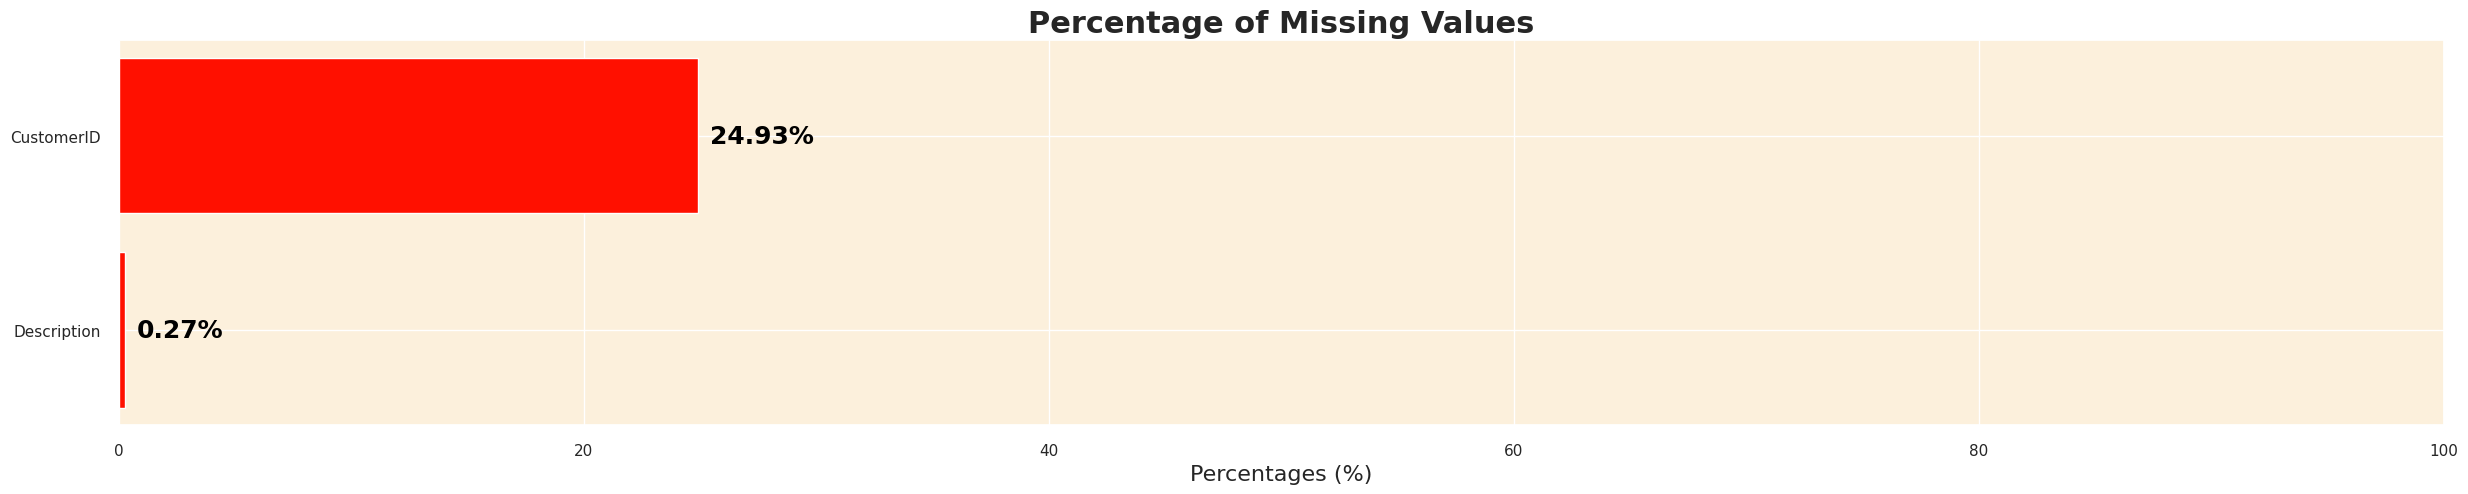

In [ ]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.barh(missing_percentage.index, missing_percentage, color='#ff1000')
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')
ax.set_xlim([0, 100])
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()


* La colonne CustomerID contient près d'un quart de données manquantes. Cette colonne est essentielle pour regrouper les clients et créer un système de recommandation. L’imputation d’un pourcentage aussi élevé de valeurs manquantes pourrait introduire un biais ou du bruit important dans l’analyse.
* On va procéder par l'élimination des valeurs manquantes:

In [ ]:
df = df.dropna(subset=['CustomerID', 'Description'])


In [ ]:
df.isnull().sum().sum()


0

## Manipulation des duplications:

In [ ]:
duplicate_rows = df[df.duplicated(keep=False)]


In [ ]:
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


*  Dans le contexte de ce projet, la présence de lignes complètement identiques, y compris des temps de transaction identiques, suggère qu'il pourrait s'agir d'erreurs d'enregistrement de données plutôt que de véritables transactions répétées. Conserver ces lignes en double peut introduire du bruit et des inexactitudes potentielles dans le système de clustering et de recommandation.


In [ ]:
print(f"le dataset contient {df.duplicated().sum()} lignes dupliquées qui vont être supprimées")

# Supprimer les duplications
df.drop_duplicates(inplace=True)

le dataset contient 5225 lignes dupliquées qui vont être supprimées


In [ ]:
# Finalement, on va travailler avec ce nombre de lignes:
df.shape[0]

401604

# Manipulation des transactions annulées:
Pour affiner notre compréhension du comportement et des préférences des clients, nous devons prendre en compte les transactions qui ont été annulées. Dans un premier temps, nous identifierons ces transactions en filtrant les lignes où le InvoiceNo commence par « C ». Par la suite, nous analyserons ces lignes pour comprendre leurs caractéristiques ou modèles communs :

In [ ]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


# Des Constatations:
* Toutes les quantités des transactions annulées sont négatives, indiquant qu'il s'agit bien de commandes annulées.
* La colonne UnitPrice présente une répartition considérable, ce qui montre qu'une variété de produits, de valeur faible à élevée, faisaient partie des transactions annulées.
#Stratégie de traitement des transactions annulées :
Compte tenu de l'objectif du projet de regrouper les clients en fonction de leur comportement d'achat et de leurs préférences et, à terme, de créer un système de recommandation, il est impératif de comprendre les modèles d'annulation des clients. Par conséquent, la stratégie consiste à conserver ces transactions annulées dans l’ensemble de données, en les marquant distinctement pour faciliter une analyse plus approfondie. Cette approche :

* Améliorez le processus de regroupement en intégrant des modèles et des tendances observés dans les données d'annulation, qui peuvent représenter certains comportements ou préférences des clients.
Permettre au système de recommandation d'empêcher éventuellement de suggérer des produits qui ont une forte probabilité d'être annulés, améliorant ainsi la qualité des recommandations.

In [ ]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

In [ ]:
print(f"Le pourcentage des transactions annulées est: {cancelled_percentage:.2f}%")

Le pourcentage des transactions annulées est: 2.21%


# Correction des anomalies de colonne StockCode:

In [ ]:
unique_stock_codes = df['StockCode'].nunique()
print(f"Le nombre de StockCode distincts est: {unique_stock_codes}")


Le nombre de StockCode distincts est: 3684


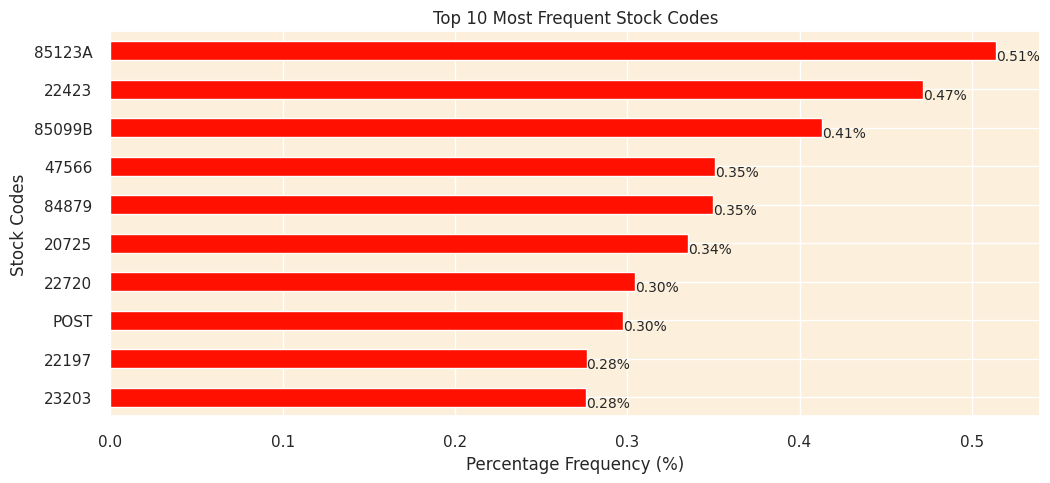

In [ ]:
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff1000')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Nombre de valeurs des fréquences de caractères numériques dans les codes de stock uniques :")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Nombre de valeurs des fréquences de caractères numériques dans les codes de stock uniques :
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [ ]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [ ]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

print(f"Le pourcentage d'enregistrements avec des codes de stock anormaux dans l'ensemble de données est : {percentage_anomalous:.2f}%")

Le pourcentage d'enregistrements avec des codes de stock anormaux dans l'ensemble de données est : 0.48%


In [ ]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]
df.shape[0]


399689

# Traitement de la colonne Description:

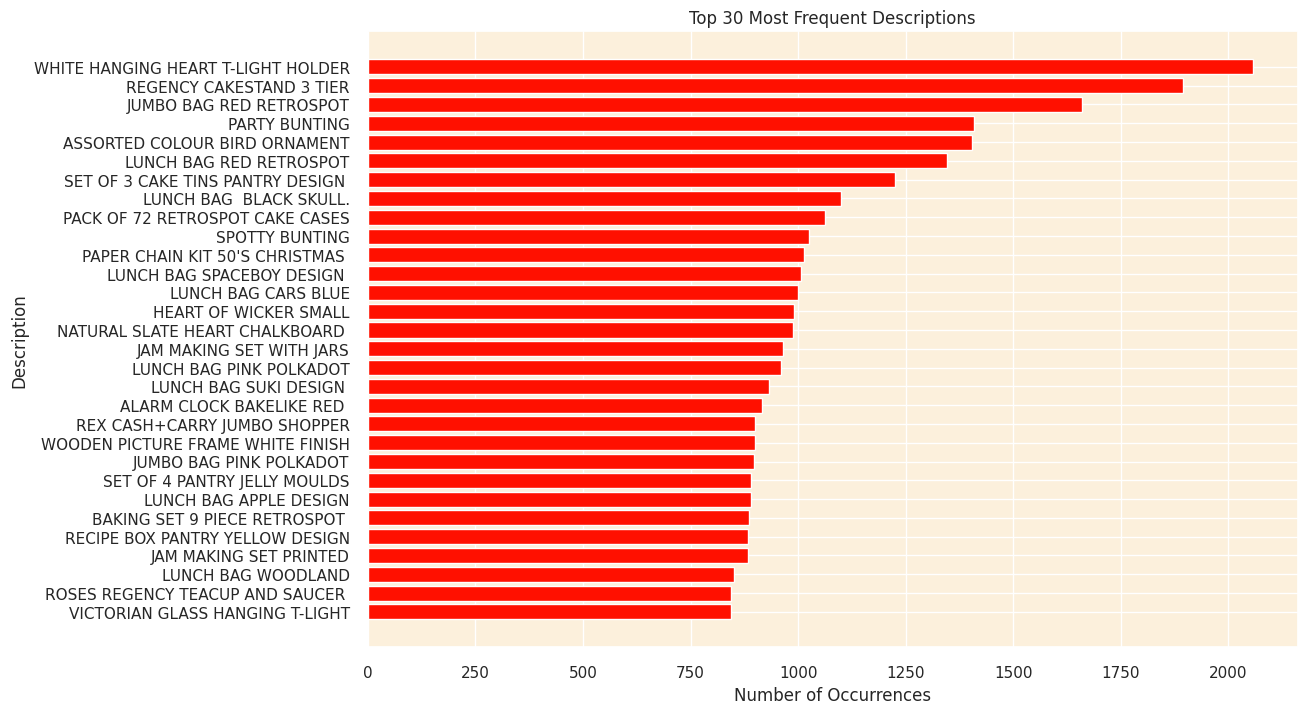

In [ ]:
# On identifie les colonnes distinctes:
description_counts = df['Description'].value_counts()
# Isolation des 30 descriptions les plus répétetif:
top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff1000')
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')
plt.show()

In [ ]:
# Les description ayant des caractères minuscules:
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


# Constatation:
Après avoir examiné les descriptions contenant des caractères minuscules, il est évident que certaines entrées ne sont pas des descriptions de produits, telles que "Next Day Carriage" et "High Resolution Image". Ces entrées semblent n'avoir aucun rapport avec les produits réels et peuvent représenter d'autres types d'informations ou de détails de service.

# Stratégie:
Étape 1 : Supprimez les lignes dans lesquelles les descriptions contiennent des informations relatives au service, telles que "Next Day Carriage" et "High Resolution Image" , car elles ne représentent pas de produits réels et ne contribueraient pas au système de regroupement et de recommandation que nous souhaitons créer.

Étape 2 : Pour les descriptions restantes avec une casse mixte, standardisez le texte en majuscules pour maintenir l'uniformité dans l'ensemble de données. Cela contribuera également à réduire les risques d'entrées en double avec des styles de cas différents.
En mettant en œuvre la stratégie ci-dessus, nous pouvons améliorer la qualité de notre ensemble de données, le rendant plus adapté aux phases d'analyse et de modélisation de notre projet.

In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

print(f"Le pourcentage d'enregistrements avec des descriptions liées au service dans l'ensemble de données est : {service_related_percentage:.2f}%")

df = df[~df['Description'].isin(service_related_descriptions)]

df['Description'] = df['Description'].str.upper()

Le pourcentage d'enregistrements avec des descriptions liées au service dans l'ensemble de données est : 0.02%


# Traitement de la colonne Unit Price:

In [ ]:
df['UnitPrice'].describe()


,UnitPrice
count,399606.000000
mean,2.904957
std,4.448796
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [ ]:
df[df['UnitPrice']==0].describe()[['Quantity']]


,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [ ]:
# Suppression des lignes ayant  unit price de zero pour éviter les erreurs d'entrée:
df = df[df['UnitPrice'] > 0]

In [ ]:
df.reset_index(drop=True, inplace=True)

# Feature Engineering:

## RFM Features:

RFM est une méthode utilisée pour analyser la valeur client et segmenter la clientèle. C'est un acronyme qui signifie :

* Récence (R) : cette mesure indique la date à laquelle un client a effectué un achat. Une valeur de récence plus faible signifie que le client a acheté plus récemment, ce qui indique un engagement plus élevé envers la marque.

* Fréquence (F) : cette mesure indique la fréquence à laquelle un client effectue un achat au cours d'une certaine période. Une valeur de fréquence plus élevée indique un client qui interagit plus souvent avec l'entreprise, ce qui suggère une fidélité ou une satisfaction plus élevée.
* Monétaire (M) : cette mesure représente le montant total d’argent qu’un client a dépensé sur une certaine période. Les clients qui ont une valeur monétaire plus élevée ont contribué davantage à l’entreprise, ce qui indique leur valeur potentielle élevée à vie.

Ensemble, ces mesures aident à comprendre le comportement d'achat et les préférences d'un client, ce qui est essentiel pour personnaliser les stratégies marketing et créer un système de recommandation.

## Recence:

In [ ]:
# InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Date d'achat la plus récente pour chaque client:
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Data la plus récente:
most_recent_date = df['InvoiceDay'].max()

customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Nombre de jour dés le dernier achat pour chaque client:
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [ ]:
customer_data.head()


,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


# Fréquence:

In [ ]:
# nombre de transactions pour chaque client
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# nombre de produits achetés pour chaque client:
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


#Monétaire

In [ ]:
# Total pour chaque client:
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Moyenne d'une transaction pour chaque client:
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


# Diversité des produits:

In [ ]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


#Caractéristiques comportementales

In [ ]:
# Extraire les jours de la semaines de InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Moyenne denombre de jours entre deux achats consécutives:
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Trouver le jour favori
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Heure favorie
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


# Caractéristiques Géographiques:

In [ ]:
df['Country'].value_counts(normalize=True).head()


,proportion
Country,
United Kingdom,0.890971
Germany,0.022722
France,0.020402
EIRE,0.018440
Spain,0.006162


In [ ]:
# Regrouper par CustomerID et Country pour obtenir le nombre de transactions par pays pour chaque client
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Obtenir le pays avec le nombre maximum de transactions pour chaque client (au cas où un client aurait des transactions provenant de plusieurs pays)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Créer une colonne binaire indiquant si le client vient du Royaume-Uni ou non
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [ ]:
customer_data['Is_UK'].value_counts()


,count
Is_UK,
1,3866
0,416



#Informations sur l'annulation

In [ ]:
# Nombre de transactions par chaque client:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Nombre de transactions annulées par chaque client:
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


# Saisonnalité et tendances




In [ ]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Dépenses mensuelles:
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Patrpns de saisonalité d'achats:
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Remplacer le NaN par des 0
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Tendances de dépenses:
def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [ ]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()


In [ ]:
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


# Détection et traitement des valeurs aberrantes:

In [ ]:
# On va utiliser l'Isolation Forest Model:
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


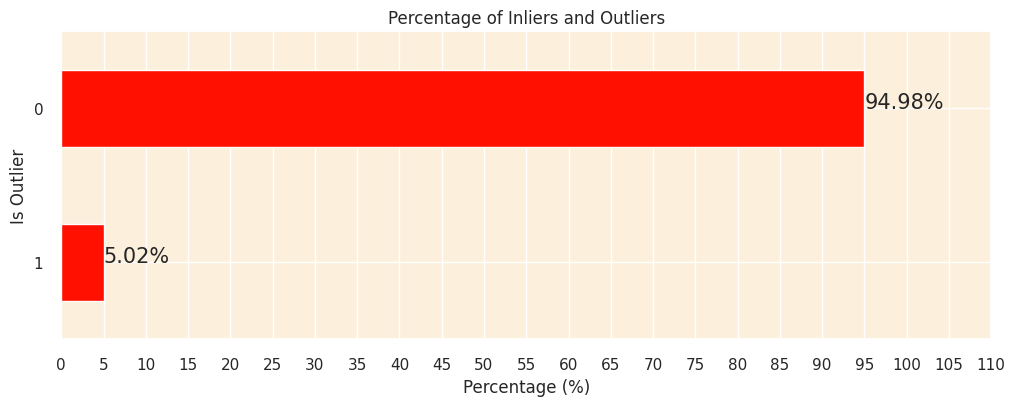

In [ ]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff1000')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Séparation des valeurs aberrantes pour l'analyse:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Suppression des valeurs aberrantes de la dataset principale:
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)


# Analyse de correlation:



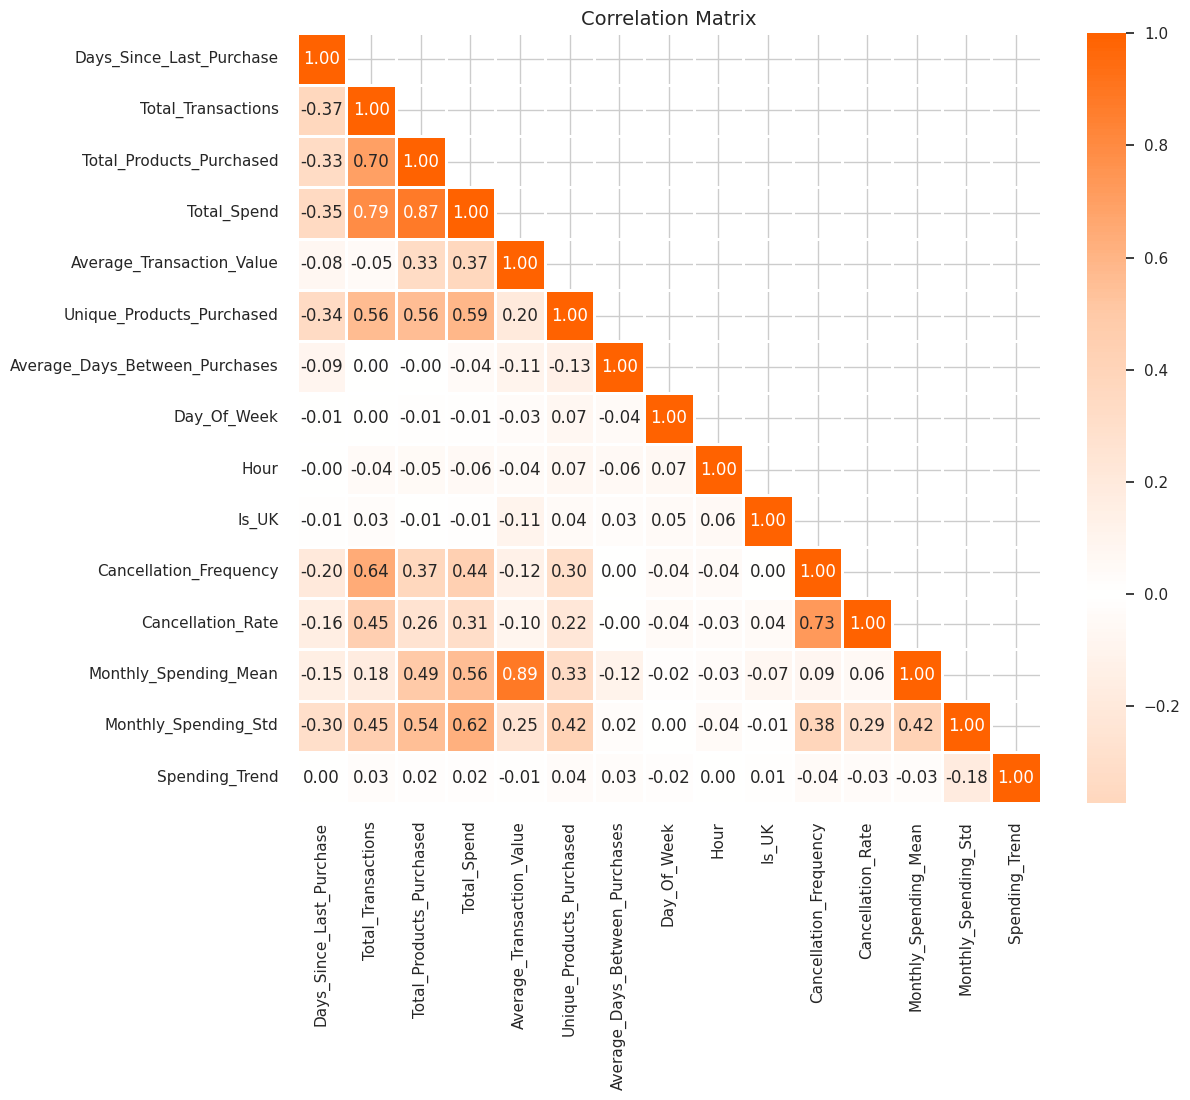

In [ ]:
sns.set_style('whitegrid')

# Matrice de correlation
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)


mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

#heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

# Mise à l'échelle

In [ ]:
scaler = StandardScaler()

columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


# Réduction de la dimensionalité:

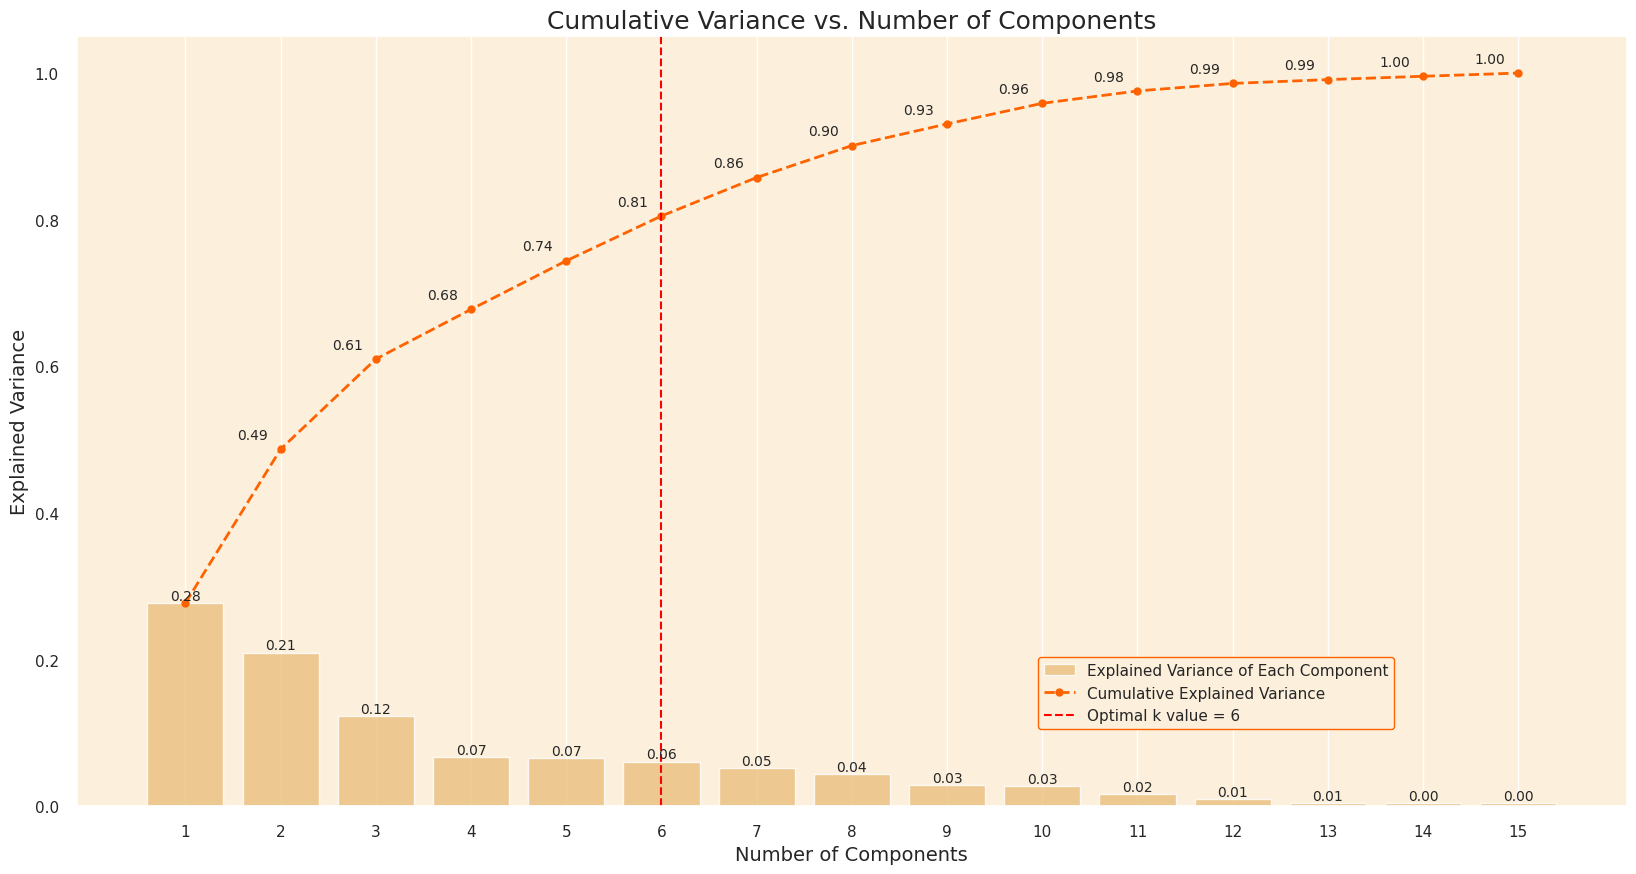

In [ ]:
customer_data_scaled.set_index('CustomerID', inplace=True)

pca = PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# On va choisir notre k optimal à 6
optimal_k = 6

sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

#Tracer la variance expliquée cumulée par rapport au nombre de composants
plt.figure(figsize=(20, 10))

# Bar chart pour la variance de chaque composant
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [ ]:
pca = PCA(n_components=6)

customer_data_pca = pca.fit_transform(customer_data_scaled)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

customer_data_pca.index = customer_data_scaled.index
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,-1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,-0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,-0.183682,-1.484838,0.062672


In [ ]:
# Definir une fonction pour souligner le 3 meilleurs en valeurs absolue
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

In [ ]:
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,-0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,-0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,-0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,0.013419,-0.005353,0.014384


# K-Means Clustering:

##Determiner le nombre de Clusters optimal



Pour déterminer le nombre optimal de clusters (k) pour segmenter les clients, j'explorerai deux méthodes renommées :

Méthode du coude

Méthode des silhouettes

Il est courant d'utiliser les deux méthodes dans la pratique pour corroborer les résultats.

###Méthode du coude

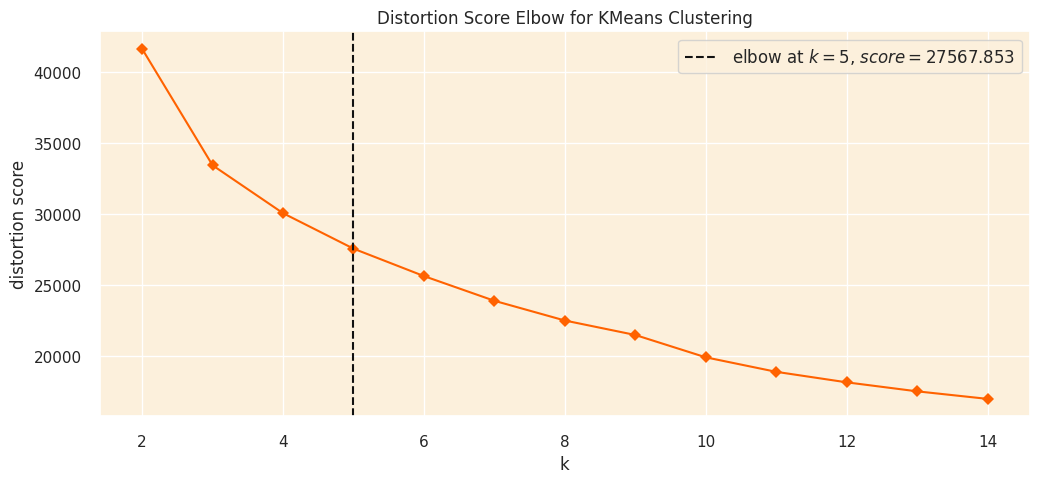

In [ ]:
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

sns.set_palette(['#ff6200'])

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12, 5))

visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

visualizer.fit(customer_data_pca)

visualizer.show();


###Méthode des silhouettes

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    plt.figure(figsize=figsize)

    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    first_plot = plt.subplot(grid[0, :])

    sns.set_palette(['darkorange'])

    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

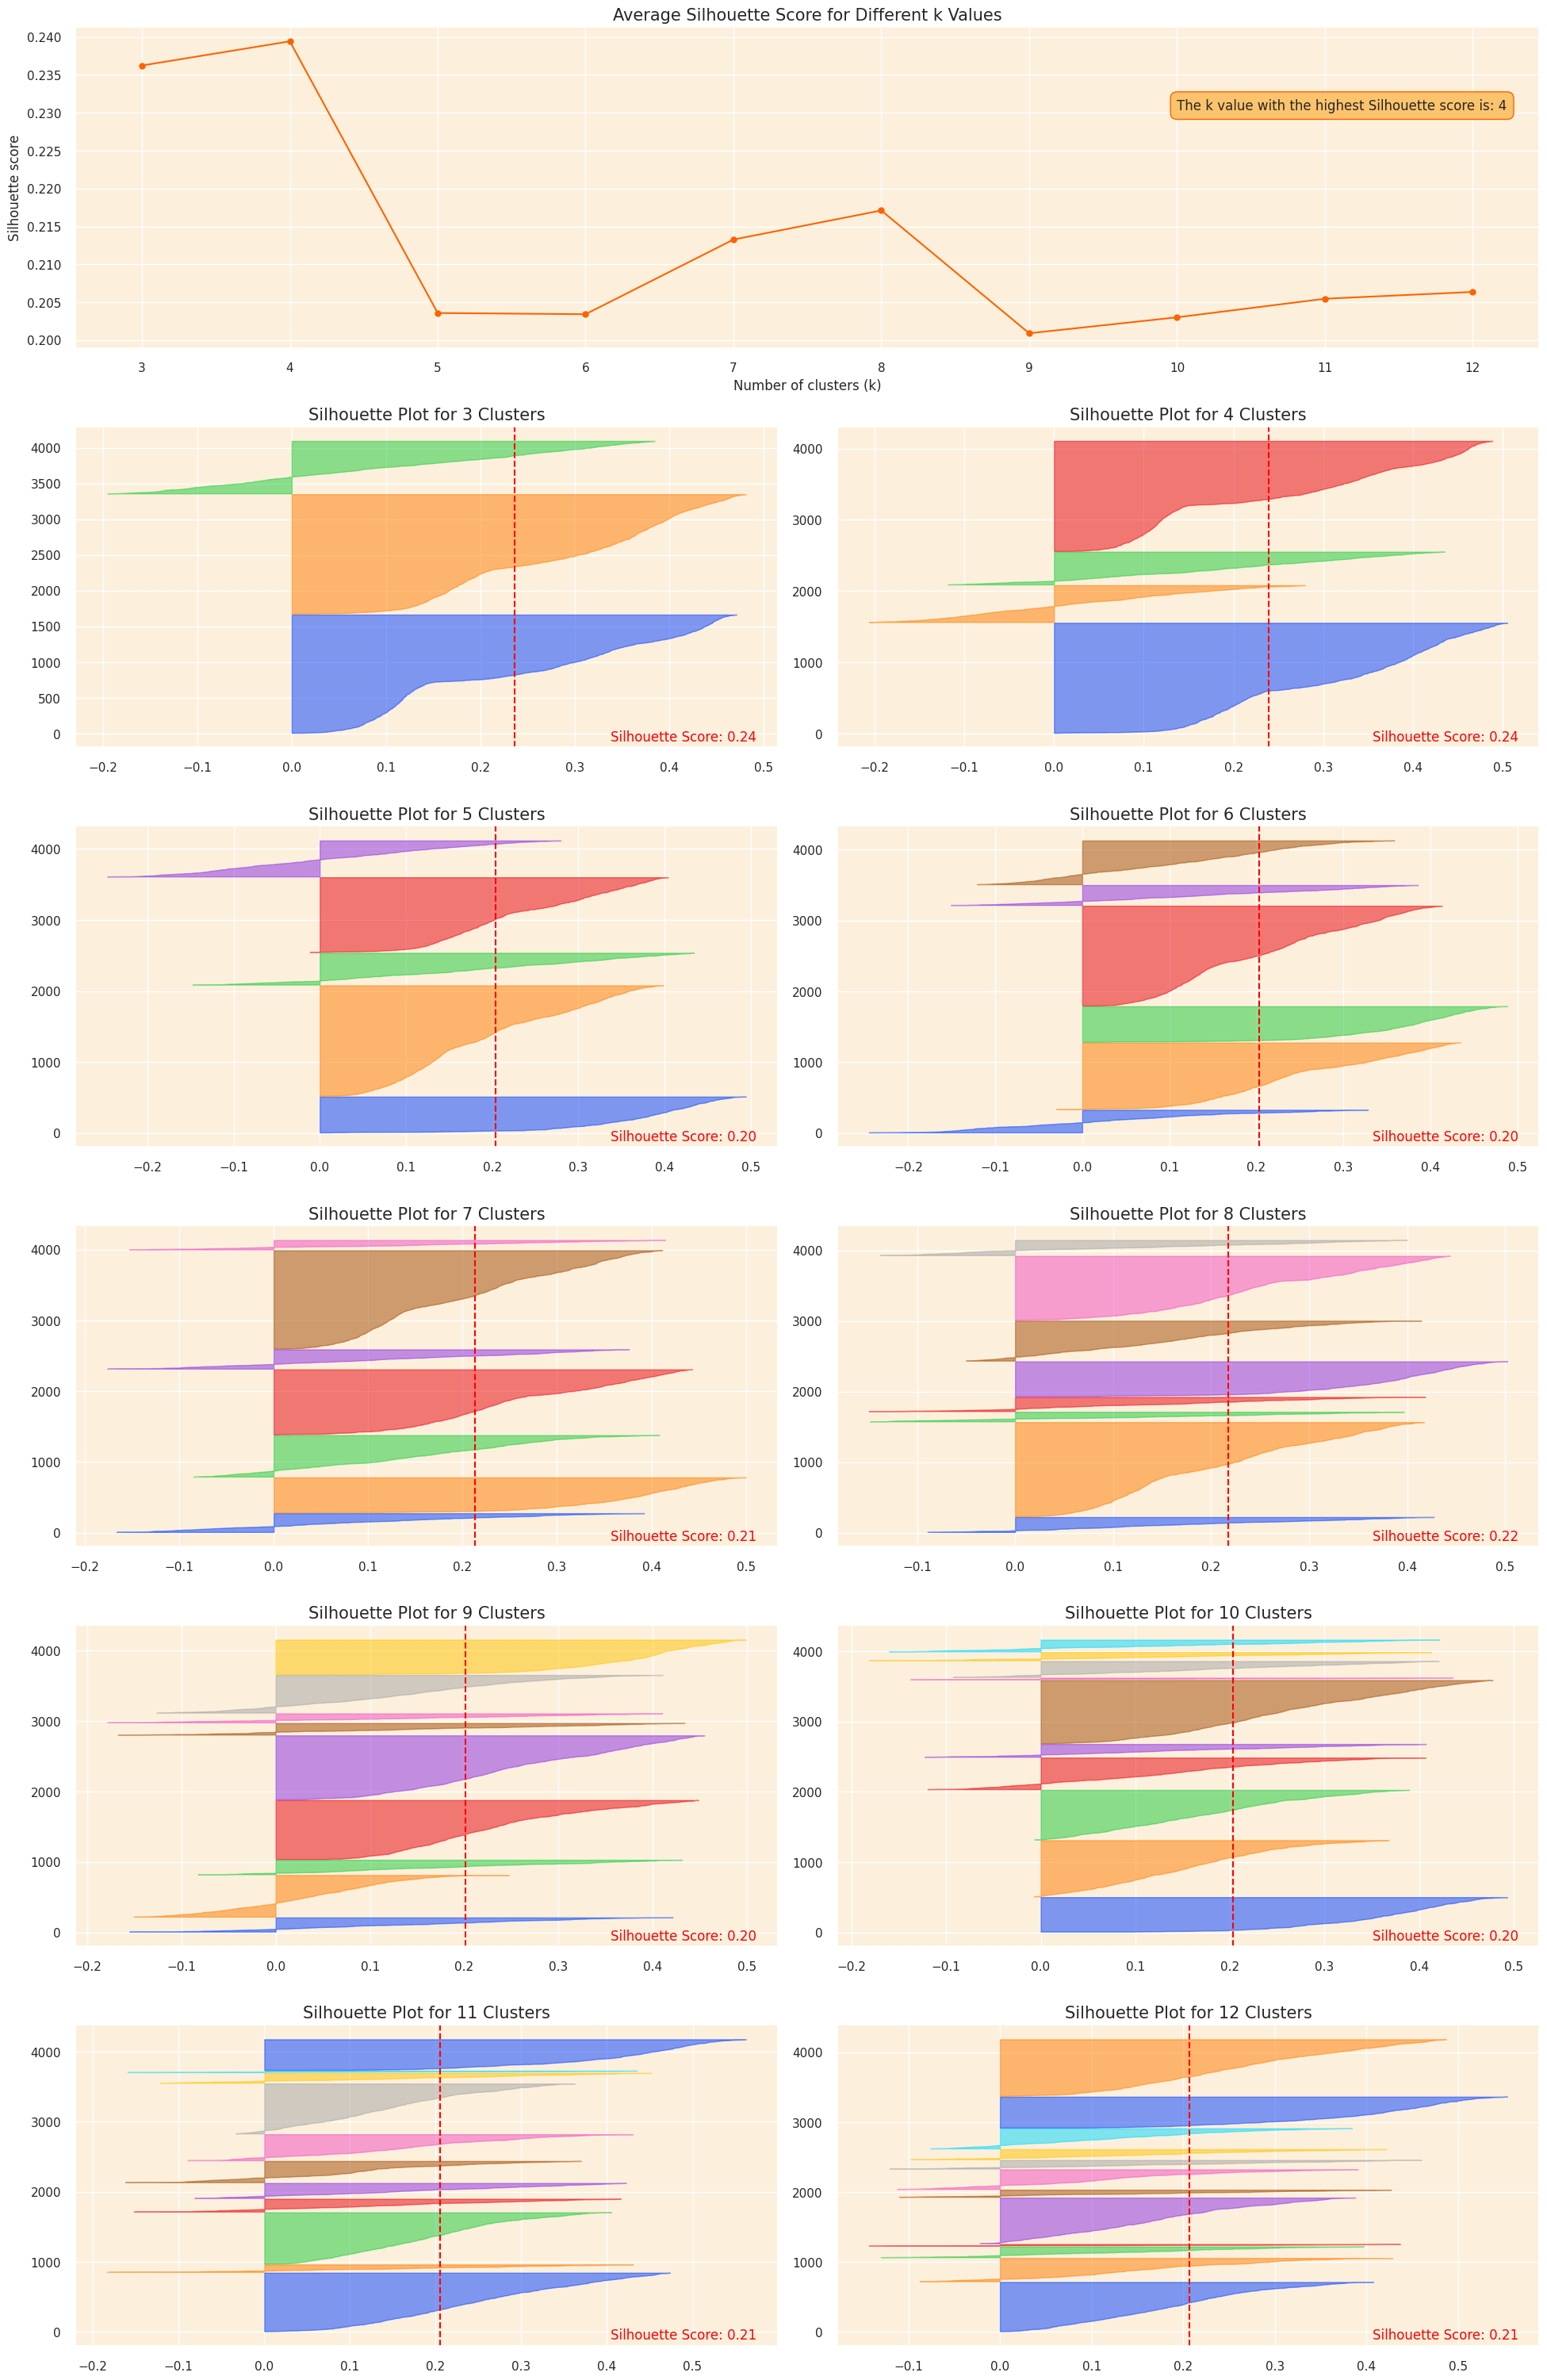

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))


# Kmeans avec k=4:

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [ ]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,2
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,2
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2


# Evaluation du Clustering:

# Visualization de la distribution des clusters:

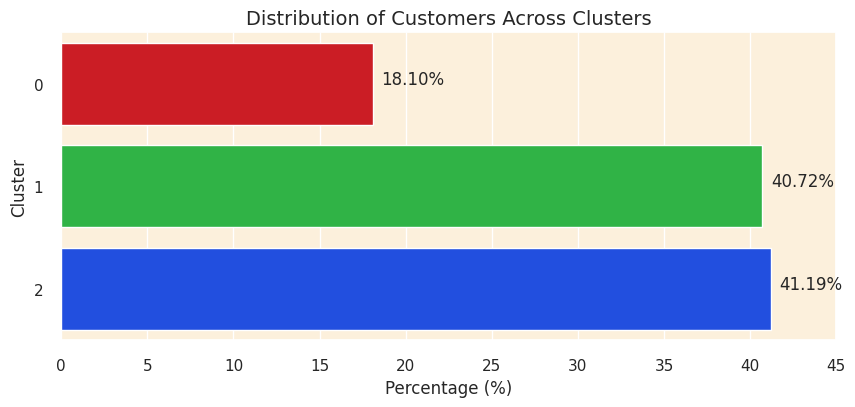

In [ ]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()


# Métriques d'évaluation:
Pour examiner plus en détail la qualité de notre clustering, nous utilisons les métriques suivantes :

* Score Silhouette : une mesure permettant d'évaluer la distance de séparation entre les clusters. Des valeurs plus élevées indiquent une meilleure séparation des clusters. Il varie de -1 à 1.
* Score Calinski Harabasz : ce score est utilisé pour évaluer la dispersion entre et au sein des clusters. Un score plus élevé indique des clusters mieux définis.
* Score Davies Bouldin : il évalue la similarité moyenne entre chaque cluster et son cluster le plus similaire. Des valeurs inférieures indiquent une meilleure séparation des clusters.


In [ ]:
# Nombre de clients
num_observations = len(customer_data_pca)


X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Calcul des métriques
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23622848017098874 |
| Calinski Harabasz Score | 1257.1747766540636  |
|  Davies Bouldin Score   | 1.3682695376074665  |
+-------------------------+---------------------+


#  Analyse et profilage de cluster:
Pour cela, on va adopter une approche Radar-chart et une approche en histogramme

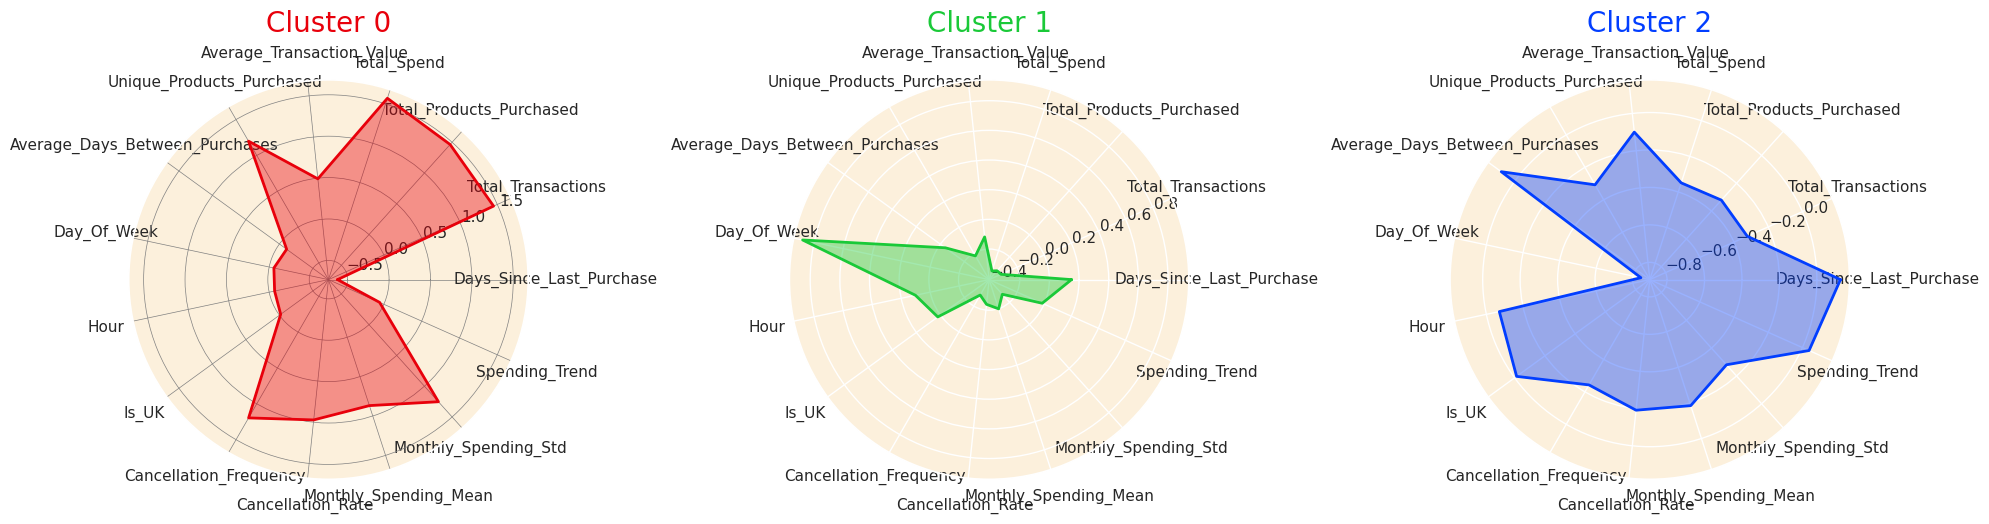

In [ ]:
df_customer = customer_data_cleaned.set_index('CustomerID')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

ax[0].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

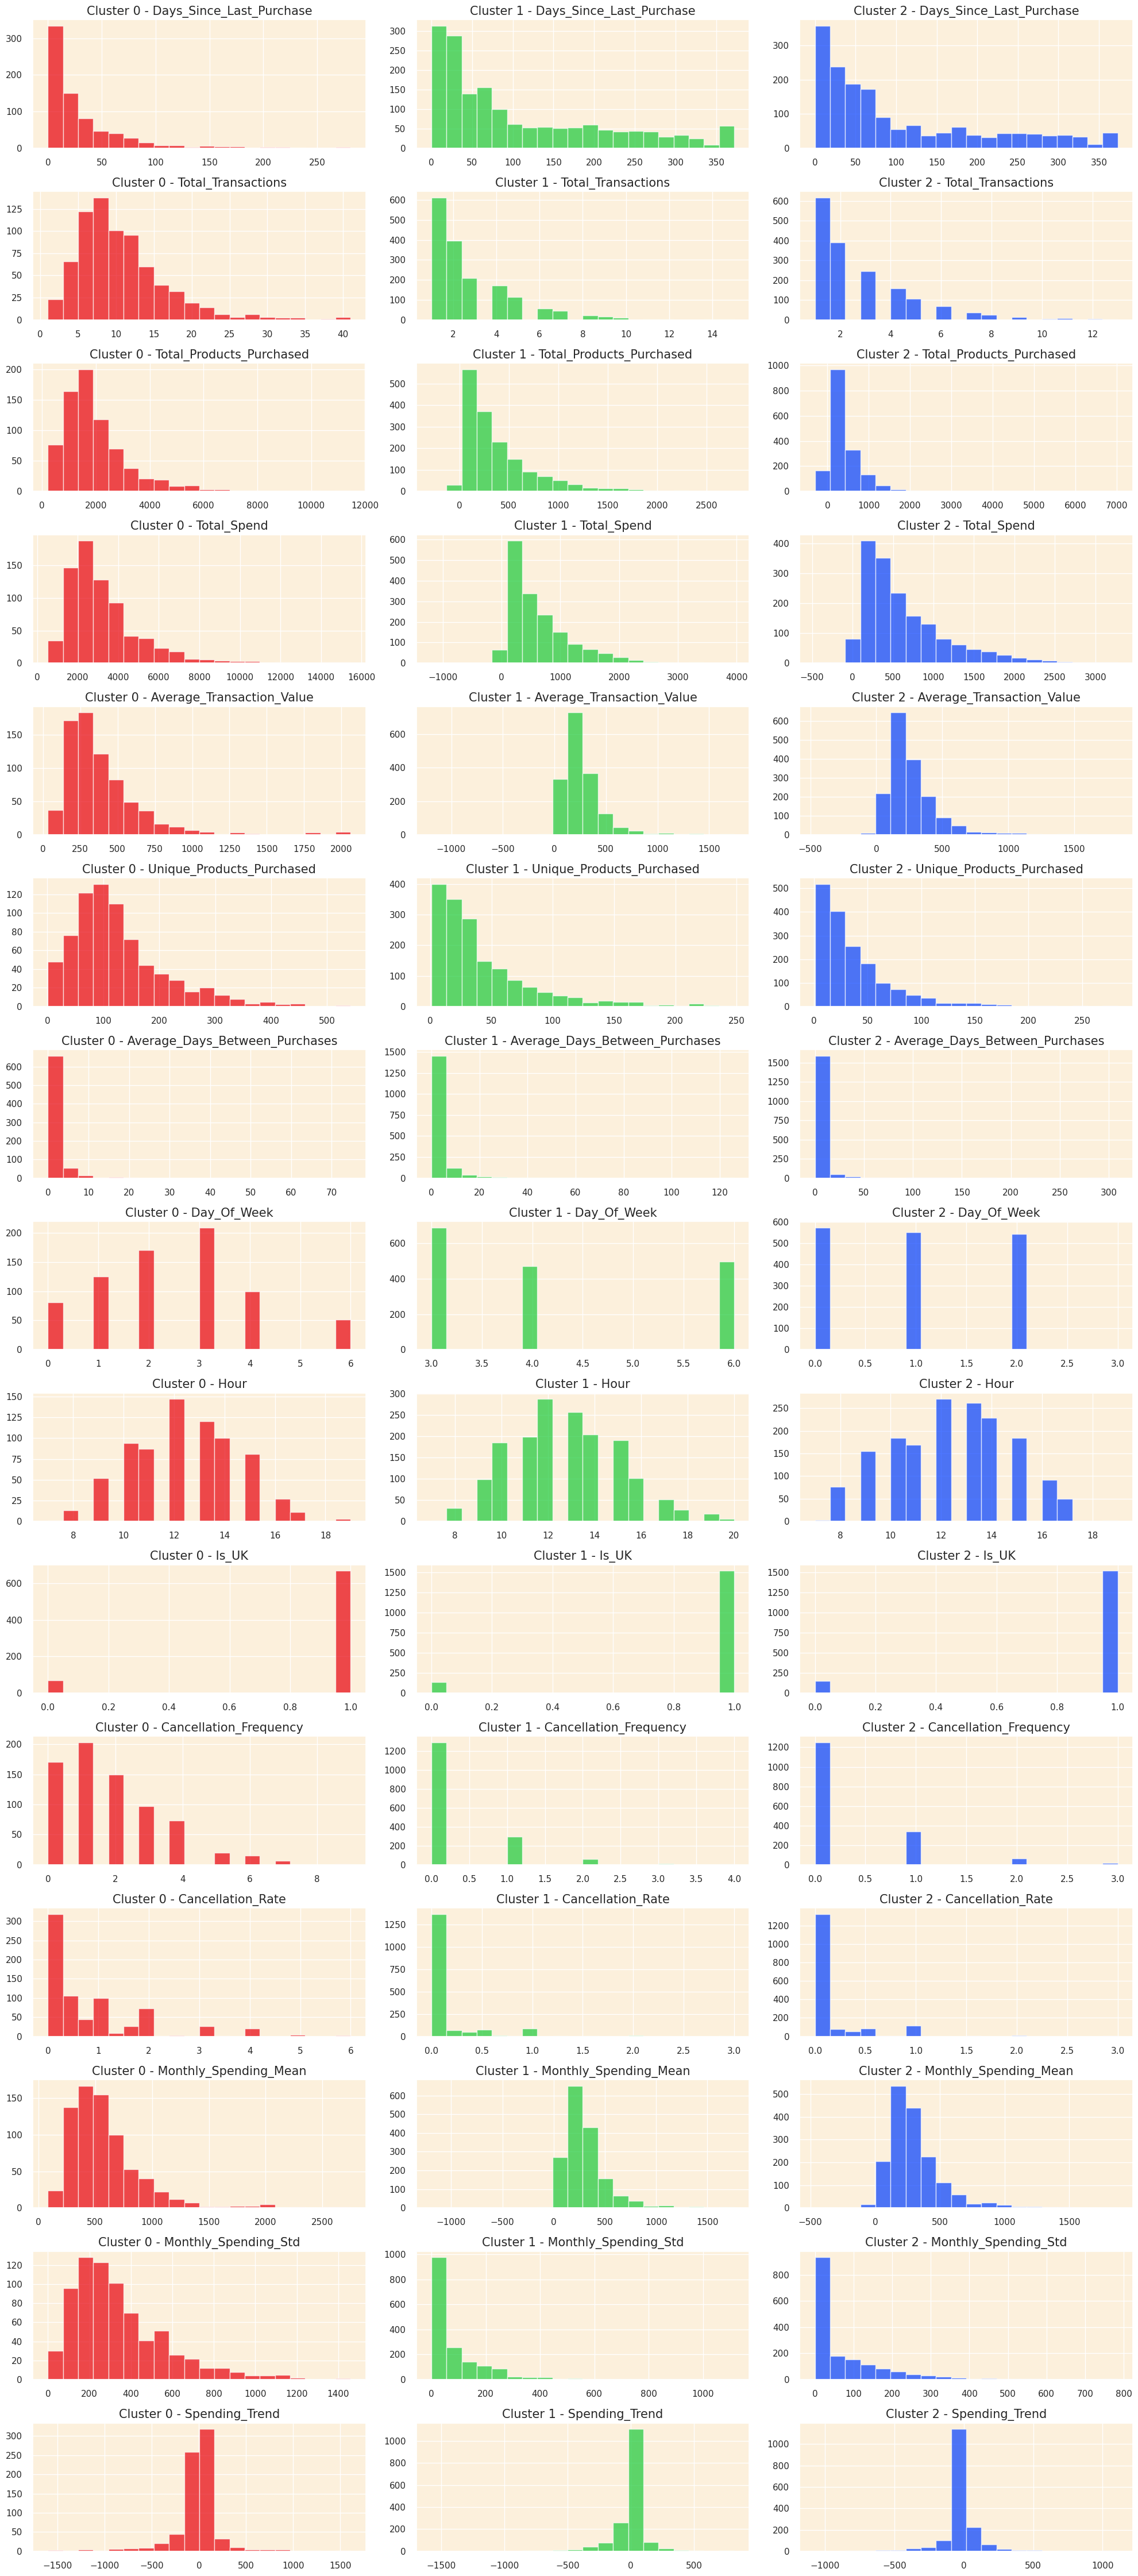

In [ ]:
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

# Système de recommendation:

Dans la phase finale de ce projet, nous allons développer un système de recommandation pour améliorer l'expérience d'achat en ligne. Ce système proposera des produits aux clients en fonction des modèles d'achat prédominants dans leurs clusters respectifs. Plus tôt dans le projet, lors de la phase de préparation des données client, nous avons isolé une petite fraction (5 %) des clients identifiés comme aberrants et les ai réservés dans un ensemble de données distinct appelé outliers_data.

Désormais, en se concentrant sur les 95 % principaux du groupe de clients, nous analysons les données clients nettoyées pour identifier les produits les plus vendus au sein de chaque cluster. En exploitant ces informations, le système élaborera des recommandations personnalisées, suggérant les trois produits les plus populaires au sein de leur cluster qu'ils n'ont pas encore achetés. Cela facilite non seulement les stratégies marketing ciblées, mais enrichit également l'expérience d'achat personnelle, augmentant potentiellement les ventes. Pour le groupe des personnes aberrantes, une approche de base pourrait consister à recommander des produits aléatoires, comme point de départ pour les impliquer.

In [ ]:
# Étape 1 : Extrayez les ID client des valeurs aberrantes et supprimez leurs transactions de la trame de données principale
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Étape 2 : garantir un type de données cohérent pour CustomerID dans les deux trames de données avant la fusion
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Étape 3 : Fusionnez les données de transaction avec les données client pour obtenir les informations de cluster pour chaque transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Étape 4 : Identifiez les 10 produits les plus vendus dans chaque cluster en fonction de la quantité totale vendue
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Étape 5 : Créer un enregistrement des produits achetés par chaque client dans chaque cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Étape 6 : Générer des recommandations pour chaque client dans chaque cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Les produit déjà acheté par le client
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # 3 best sellers que le client n'a pas encore acheté
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Étape 7 : Créer un dataframe à partir de la liste de recommandations et fusionnez-le avec les données client d'origine

recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [ ]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
13243.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
13232.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14997.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14948.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
12596.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
16686.0,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17101.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14954.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
18123.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
